# Solutions: nearest neighbors computation

This notebook contains practical exercise to manipulate the $k$ nearest neighbors of a particular observation under study, the so called **kNN aglorithm**, standing for *k Nearest Neighbor*.

## Import and pseudo-datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Plot settings
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.fontsize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['figure.figsize'] = (10, 7)

The following piece of code create two reference dataset (*training*) containing 1 million observation, each observation consist of 25 variables (or *features*). For the purpose of the exercise, we use gaussian numbers with a mean of -2.5 and +2.5 for training dataset 1 and 2 respectively (both having a RMS of 5).

In [3]:
# Generation of two (training) datasets of 10e6 observations contanining 25 features each
Nobs = 1000000
trainX1 = 5.0*np.random.randn(Nobs,25) - 2.5
trainX2 = 5.0*np.random.randn(Nobs,25) + 2.5

Since our training dataset is known, it can be useful to consider labels associated to each event. This label is the property we might want to predict for a new, unknown observation. We decide to label `trainX1` with `1` and `trainX2` with `2`:

In [4]:
# Create the target (or label for each dataset)
trainY1 = np.zeros(Nobs)+1
trainY2 = np.zeros(Nobs)+2

## Quick data inspection

Plot and compare the distribution of the first variables for `dataX1` and `dataX2`

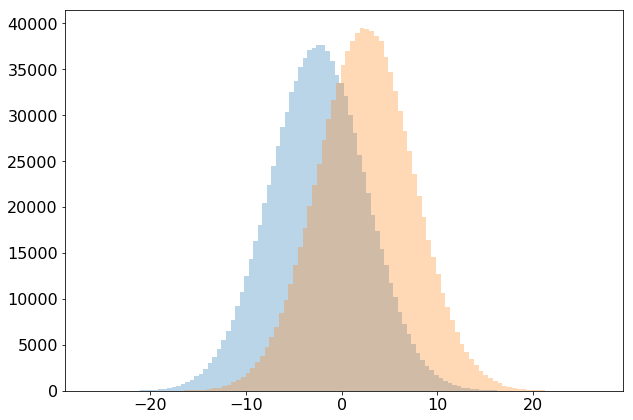

In [5]:
# Plotting the distributions of the first feature
plt.hist(trainX1[:, 0], bins=100, alpha=0.3)
plt.hist(trainX2[:, 0], bins=100, alpha=0.3);

## Nearest neighbors of a new observation `obs`

In [6]:
# compute distances for a test observation
obs = np.random.randn(25)
print(obs)

[-0.66949702  0.90758286 -0.23019573 -0.63474657 -0.05106162 -1.85110552
  2.55393216  0.34754116 -0.24648303 -0.70149329 -0.02215666  0.20624167
 -1.0469804   1.39196367 -0.13784924 -1.01227198 -1.15605235  0.82405666
 -0.83293886 -0.96144264 -1.53850312  0.70726616 -0.97153848  0.05854317
 -0.04713646]


### Merge the two datasets `X` and `Y`

The idea is to manipulate a single array `trainX` for the features regardless of the type of data (1 or 2), while keeping track of the label with a single `trainY` array:

In [7]:
trainX = np.concatenate([trainX1, trainX2])
trainY = np.concatenate([trainY1, trainY2])

### Compute the distance between `obs` and the global dataset

Using broadcasting and vectorized operation, compute the euclidien distance in the 25 dimension space between the unknown observation and every point of the global dataset (containing both data of type 1 and 2).

In [8]:
distances = np.sum((trainX-obs)**2, axis=1)**(0.5)

### Sort the distances to have the nearest points first

In this question, we want to sort distances by increasing order (to later take only the $k$ first ones), and the associated type of neighbors (1 or 2). 

**HINT:** this can be done using the function `np.argsort()`.

In [9]:
# Get the point indices by increasing distances
sorted_points = np.argsort(distances)

# Get the sorted distances
sdistances = distances[sorted_points]

# Get the corresponding data type
sorted_trainY = trainY[sorted_points]

### Count the number of nearest neighbors of type 1 and type 2 

We would like to consider the k nearest neighbors, and count the fraction of type 1 and type 2 data (to later be able to say if our unknown observation is more likely to be of type 1 or 2). Of course, if we consider the whole training points (`k=Nobs`), there will be `Nobs` points of type 1 and `Nobs` points of type 2. This is why it is interesting to compute the number of type 1 and type 2 neihbors *as a function of k*. We will consider all k values from 1 to 500.

**HINT:** the function `np.cumsum()` might be useful.

In [10]:
# Get the number of neighbor type 1 and type 2 among the k nearest neighbor
Nb1 = np.cumsum(sorted_trainY==1)
Nb2 = np.cumsum(sorted_trainY==2)

# Consider only the k values from 1 to 500
Nb1 = Nb1[:500]
Nb2 = Nb2[:500]

Plot the number of neighbors of type 1 and type 2 as a function of $k$

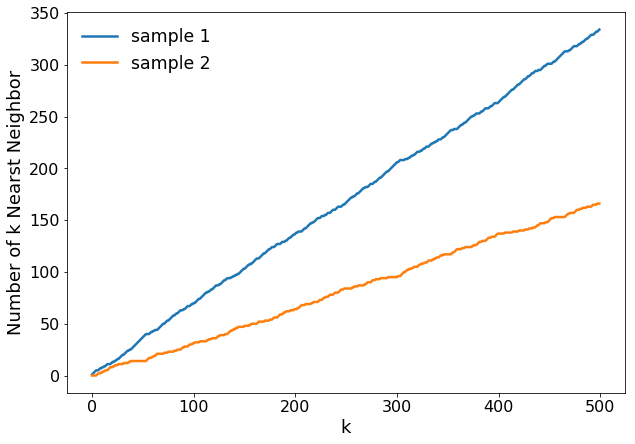

In [11]:
plt.plot(Nb1, label='sample 1')
plt.plot(Nb2, label='sample 2')
plt.ylabel('Number of k Nearst Neighbor')
plt.xlabel('k')
plt.legend();

### Create a function `get_kNN()` doing all this at once

We want now to have a function taking in argument an observation, a training sample trainX and a target trainY *with an arbitray number of type of data*, which returns the number of nearest neighbors up to kmax for each data type (formated into a list).

In [12]:
def get_kNN(obs, trainX, trainY, kmax=500):
    
    '''
    Compute the number of nearest neighbors (up to kmax) of an 
    observation `obs` with a training sample `trainX` labled 
    with `trainY`.
    
    return [N1, N2, ... Nj] (list of neighbors number for each k<kmax)
    '''
    
    # Compute distances
    r = np.sum((trainX-obs)**2, axis=1)**(0.5)
    
    # Sort the distances
    sorted_NN = np.argsort(r)
    sorted_trainY = trainY[sorted_NN]
    
    # Get the number of labels
    labels = np.unique(trainY)
    
    # Loop over labels and count the number of  nearest neighbors
    res = [np.cumsum(sorted_trainY==l)[:kmax] for l in labels]
    
    # Return the array of number of nearest neighbor
    return res


def plot_kNN(kNN_array):
    for i, kNN in  enumerate(kNN_array):
        plt.plot(kNN, label='Sample {}'.format(i+1))
    plt.ylabel('Number of k Nearst Neighbors')
    plt.xlabel('k')
    plt.legend()
    return

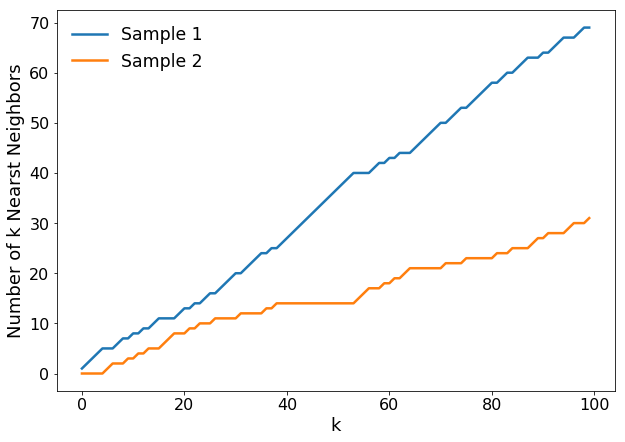

In [13]:
# Plot one observation
kNN = get_kNN(obs, trainX, trainY, kmax=100)
plot_kNN(kNN)

## Nearest neighbors of a new set of unknown observations `testX`

In [18]:
def get_kNN_vec(dataX, trainX, trainY, kmax=500):
    
    '''
    Compute the number of nearest neighbors (up to kmax) of an 
    observation `o` for two sample `d1` and `d2`.
    
    return N1, N2 (array of neighbors in data1 and data2 in the kmax nearest ones)
    '''
    
    # Get some numbers (o must be a 2D array)
    nd, nv = dataX.shape[0], dataX.shape[1]
    nt = trainX.shape[0]
    
    # Prepare proper broadcasting
    trainX = trainX.reshape(1, nt, nv)
    dataX = dataX.reshape(nd, 1, nv)
    
    # Compute distances
    r = np.sum((trainX-dataX)**2, axis=2)**(0.5)
    
    # Sort the distances along distances
    sorted_NN = np.argsort(r, axis=1)
    sorted_trainY = trainY[sorted_points]
    
    # Get the number of labels
    labels = np.unique(trainY)
    
    # Loop over labels and count the number of  nearest neighbors
    res = [np.cumsum(sorted_trainY==l)[:, :kmax] for l in labels]
    
    # Return the array of number of nearest neighbor
    return res

In [19]:
def kNNprediction(d, t1, t2, k=100, n=500):
    n1, n2 = t1.shape[0], t2.shape[0]
    d1, d2 = t1[::int(n1/n)], t2[::int(n2/n)]
    return get_kNN_vec(d, d1, d2, k)

In [20]:
# Generate pseudo data like data1 and data2
data_obs_like1 = 3*np.random.randn(10000,25)-2
data_obs_like2 = 3*np.random.randn(10000,25)+1.5

In [21]:
# # Compute the number of kNN for training1, training2
# kmax = 200
# obs1_N1, obs1_N2 = kNNprediction(d=data_obs_like1, t1=data1, t2=data2, k=kmax)
# obs2_N1, obs2_N2 = kNNprediction(d=data_obs_like2, t1=data1, t2=data2, k=kmax)

test = kNNprediction(data_obs_like1, trainX, trainY)

IndexError: index 851122 is out of bounds for axis 1 with size 500

In [ ]:
style = {'bins': np.linspace(0, 1, 50), 'alpha': 0.5}
plt.hist(obs1_N1/kmax, **style, label='Data1_like observations')
plt.hist(obs2_N1/kmax, **style, label='Data2_like observations');
plt.xlabel('Fraction of data1 neighbors in the {} nearest ones'.format(kmax))
plt.legend();

## Details of sorting and take_along_axis functions

In [20]:
# Define 2 observations with 3 neighbors
a = np.array([
    [[0.3, 1],
    [0.2, 1],
    [0.5, 2]],
    
    [[0.47, 2],
    [0.23, 2],
    [0.15, 1]]])
print('(Nevt, k, distance+label) = {}'.format(a.shape))

(Nevt, k, distance+label) = (2, 3, 2)


In [34]:
# Get sorted index along axis=(0, 1) based on the distance
ikd = np.argsort(a[:, :, 0])
print(ikd.shape)
print(ikd)

(2, 3)
[[1 0 2]
 [2 1 0]]


In [36]:
# Use fancy indexing in nd array based on broadcasted index arrays
ix = np.arange(a.shape[0]) # create 1D index with Nevt 
ix = ix[:, np.newaxis]     # add a new axis for broadcasting with 2D ikd array
a[ix, ikd]                 # take ix for axis=0 and ikd for axis=(1, 2)

array([[[0.2 , 1.  ],
        [0.3 , 1.  ],
        [0.5 , 2.  ]],

       [[0.15, 1.  ],
        [0.23, 2.  ],
        [0.47, 2.  ]]])

In [61]:
# This logic is implemented in the take_along_axis function
np.take_along_axis(a, ikd[:, :, np.newaxis], axis=1)

array([[[0.2 , 1.  ],
        [0.3 , 1.  ],
        [0.5 , 2.  ]],

       [[0.15, 1.  ],
        [0.23, 2.  ],
        [0.47, 2.  ]]])

## Next step/doc

1. Understand how the function `np.take_along_axis()` works exactly?
https://stackoverflow.com/questions/47044792/sort-invariant-for-numpy-argsort-with-multiple-dimensions , which requires to better understand fancy indexing ...
2. How to not redo the distance between a point and all the training points for a new observation? This is apparently not possible with kNN algo: This refers to *lazy* versus *eager* learner.
3. Re-write the main function for an arbitrary number of populations `di`

# Trying with one dataset label in possibly many categories

In [143]:
Nobs = 1000000
mulist = [-5, -2, 0, 2, 5]
dlist = [5.0*np.random.randn(Nobs,25)+mu for mu in mulist]
llist = [np.zeros(Nobs)+i for i in np.arange(len(mulist))]

In [144]:
trainX = np.concatenate(dlist)
trainY = np.concatenate(llist)

In [73]:
def get_kNN(dataX, trainX, trainY, k=500):
    
    '''
    Compute the number of nearest neighbors (up to k) on a data sample 
    `d` for a traning sample `t` and its label `l`.
    
    return [N1, N2, ... , Nnl] (array of neighbors in each label value
    in the kmax nearest ones)
    '''
    
    # Sanity checks
    if d.ndim != 2:
        raise NameError('Data must be a 2D array')
    if t.shape[0] != l.shape[0]:
        raise NameError('Training dataset and label must have the same size')
    if d.shape[1] != t.shape[1]:
        raise NameError('Test and training dataset must have the same number of features')
    
    # Get some numbers (o must be a 2D array)
    nd, nv = d.shape[0], d.shape[1]
    nt = t.shape[0]
    
    # Prepare proper broadcasting
    t = t.reshape( 1, nt, nv)
    d = d.reshape(nd,  1, nv)
    
    # Compute distances
    r = np.sum((d-t)**2, axis=2)**(0.5)
    
    # Sort the distances along distances
    si = np.argsort(r)
    sl = l[si]
    
    # Get list of labels
    labels = np.unique(sl)
    
    # Count the number of neighbor of each label around each observation
    Nlabel_dict = {label: np.count_nonzero(sl[:, :k]==label, axis=1) for label in labels}
    
    # Return the array of number of nearest neighbor
    return Nlabel_dict

In [178]:
kmax=100
kNN1 = get_kNN(data_obs_like1, trainX[::5000], trainY[::5000], k=kmax)
kNN2 = get_kNN(data_obs_like2, trainX[::5000], trainY[::5000], k=kmax)

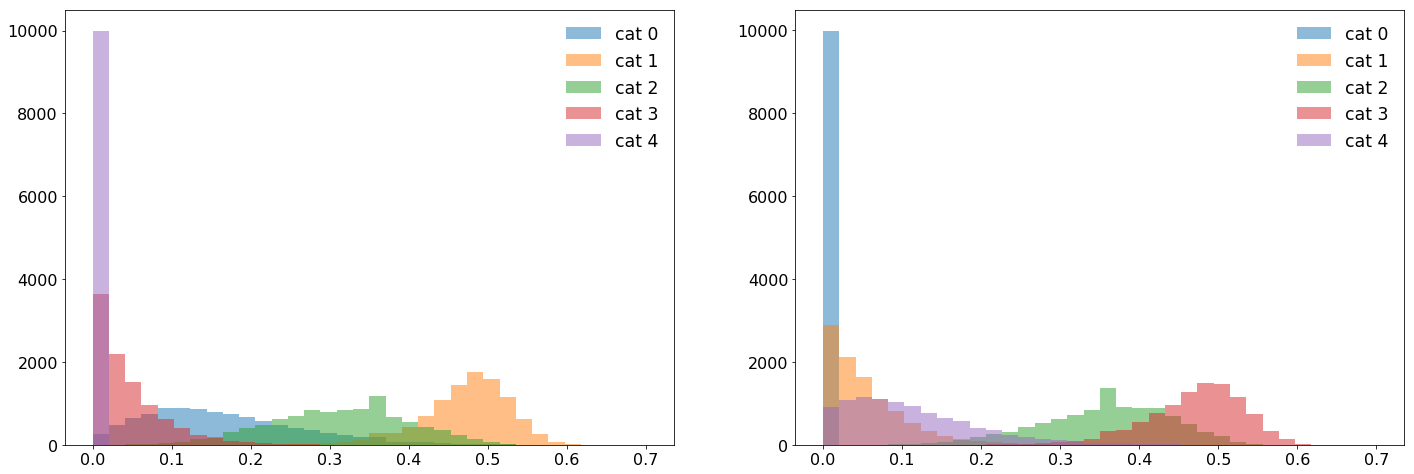

In [185]:
plt.figure(figsize=(24, 8))
plt.subplot(121)
for k, v in kNN1.items():
    plt.hist(v/kmax, label='cat {:.0f}'.format(k), alpha=0.5, bins=np.linspace(0, 0.7, 35))
plt.legend();

plt.subplot(122)
for k, v in kNN2.items():
    plt.hist(v/kmax, label='cat {:.0f}'.format(k), alpha=0.5, bins=np.linspace(0, 0.7, 35))
plt.legend();